In [9]:
import os
import numpy as np
import cv2
from pathlib import Path
import shutil
import random
import matplotlib.pyplot as plt

In [14]:
# Hàm augment sequence npy (tạo dữ liệu mô phỏng ở mức sequence)
def augment_sequence_npy(seq_folder, num_aug=2, noise_level=0.01):
    seq_folder = Path(seq_folder)
    npy_files = sorted(seq_folder.glob("*.npy"), key=lambda x: int(x.stem))
    if not npy_files:
        return
    data_seq = [np.load(f) for f in npy_files]
    data_seq = np.stack(data_seq)
    for i in range(num_aug):
        aug_seq = data_seq + np.random.normal(0, noise_level, data_seq.shape)
        aug_folder = seq_folder.parent / f"{seq_folder.name}_aug{i}"
        aug_folder.mkdir(exist_ok=True)
        for j, arr in enumerate(aug_seq):
            np.save(aug_folder / f"{j}.npy", arr.astype(np.float32))

In [15]:
# Hàm tạo dữ liệu mô phỏng cho toàn bộ dataset
def generate_synthetic_sequences(data_root, num_aug=2):
    data_root = Path(data_root)
    for action_dir in data_root.iterdir():
        if not action_dir.is_dir():
            continue
        for seq_folder in action_dir.iterdir():
            if not seq_folder.is_dir():
                continue
            augment_sequence_npy(seq_folder, num_aug=num_aug)

In [16]:
# Hàm augment sequence npy (tạo dữ liệu mô phỏng ở mức sequence)
def check_and_fix_augmented_sequences(data_root, auto_remove=True):
    data_root = Path(data_root)
    for action_dir in data_root.iterdir():
        if not action_dir.is_dir():
            continue
        print(f"🔎 Action: {action_dir.name}")
        for seq_folder in action_dir.iterdir():
            if not seq_folder.is_dir():
                continue
            if "_aug" not in seq_folder.name:
                continue
            npy_files = sorted(seq_folder.glob("*.npy"), key=lambda x: int(x.stem))
            if not npy_files:
                print(f"⚠️ {seq_folder} không có file npy")
                if auto_remove:
                    shutil.rmtree(seq_folder)
                continue
            orig_name = seq_folder.name.split("_aug")[0]
            orig_folder = seq_folder.parent / orig_name
            orig_files = sorted(orig_folder.glob("*.npy"), key=lambda x: int(x.stem))
            error = False
            if len(npy_files) != len(orig_files):
                print(f"❌ {seq_folder}: số frame khác gốc ({len(npy_files)} vs {len(orig_files)})")
                error = True
            for i, (aug_file, orig_file) in enumerate(zip(npy_files, orig_files)):
                aug_data = np.load(aug_file)
                orig_data = np.load(orig_file)
                if aug_data.shape != orig_data.shape:
                    print(f"❌ {aug_file}: shape khác gốc {aug_data.shape} vs {orig_data.shape}")
                    error = True
                if np.isnan(aug_data).any() or np.isinf(aug_data).any():
                    print(f"❌ {aug_file}: có NaN hoặc Inf")
                    error = True
                diff = np.abs(aug_data - orig_data)
                mean_diff = diff.mean()
                if mean_diff < 1e-6:
                    print(f"⚠️ {aug_file}: dữ liệu gần như trùng gốc (mean diff={mean_diff:.2e})")
                if mean_diff > 1.0:
                    print(f"⚠️ {aug_file}: dữ liệu khác biệt lớn (mean diff={mean_diff:.2f})")
            if error and auto_remove:
                print(f"🗑️ Xóa sequence lỗi: {seq_folder}")
                shutil.rmtree(seq_folder)
            else:
                print(f"✅ {seq_folder}: kiểm tra xong")
    print("🎉 Đã kiểm tra và xử lý xong dữ liệu mô phỏng!")

In [17]:
def analyze_augmented_sequences(data_root):
    data_root = Path(data_root)
    action_stats = {}
    diff_means = []
    for action_dir in data_root.iterdir():
        if not action_dir.is_dir():
            continue
        valid = 0
        error = 0
        action_diff = []
        for seq_folder in action_dir.iterdir():
            if not seq_folder.is_dir() or "_aug" not in seq_folder.name:
                continue
            npy_files = sorted(seq_folder.glob("*.npy"), key=lambda x: int(x.stem))
            orig_name = seq_folder.name.split("_aug")[0]
            orig_folder = seq_folder.parent / orig_name
            orig_files = sorted(orig_folder.glob("*.npy"), key=lambda x: int(x.stem))
            if len(npy_files) != len(orig_files):
                error += 1
                continue
            seq_error = False
            for aug_file, orig_file in zip(npy_files, orig_files):
                aug_data = np.load(aug_file)
                orig_data = np.load(orig_file)
                if aug_data.shape != orig_data.shape or np.isnan(aug_data).any() or np.isinf(aug_data).any():
                    seq_error = True
                    break
                diff = np.abs(aug_data - orig_data)
                mean_diff = diff.mean()
                action_diff.append(mean_diff)
                diff_means.append(mean_diff)
            if seq_error:
                error += 1
            else:
                valid += 1
        action_stats[action_dir.name] = {"valid": valid, "error": error, "diff_means": action_diff}
    # Vẽ biểu đồ số lượng sequence hợp lệ/lỗi
    actions = list(action_stats.keys())
    valid_counts = [action_stats[a]["valid"] for a in actions]
    error_counts = [action_stats[a]["error"] for a in actions]
    plt.figure(figsize=(8,5))
    plt.bar(actions, valid_counts, label="Valid", color="green")
    plt.bar(actions, error_counts, bottom=valid_counts, label="Error", color="red")
    plt.ylabel("Số sequence augment")
    plt.title("Số lượng sequence augment hợp lệ/lỗi theo action")
    plt.legend()
    plt.show()
    # Vẽ histogram độ khác biệt trung bình
    plt.figure(figsize=(8,5))
    plt.hist(diff_means, bins=30, color="blue", alpha=0.7)
    plt.xlabel("Mean diff giữa augment và gốc")
    plt.ylabel("Số lượng frame")
    plt.title("Phân phối độ khác biệt trung bình giữa augment và gốc")
    plt.show()
    # Vẽ boxplot cho từng action
    plt.figure(figsize=(8,5))
    plt.boxplot([action_stats[a]["diff_means"] for a in actions], labels=actions)
    plt.ylabel("Mean diff")
    plt.title("Boxplot độ khác biệt trung bình theo action")
    plt.show()

In [18]:
# Chạy augment và kiểm tra dữ liệu
DATA_PATH = "MP_Data"
NUM_AUG = 2

# Tạo dữ liệu mô phỏng
generate_synthetic_sequences(DATA_PATH, num_aug=NUM_AUG)
print("🎉 Đã tạo dữ liệu mô phỏng ở mức sequence!")

🎉 Đã tạo dữ liệu mô phỏng ở mức sequence!


In [19]:
# Kiểm tra và xử lý lỗi dữ liệu augment
check_and_fix_augmented_sequences(DATA_PATH, auto_remove=True)

🔎 Action: 0
🔎 Action: 1
🔎 Action: 2
🔎 Action: 3
🔎 Action: 4
🔎 Action: 5
🔎 Action: 6
🔎 Action: 7
🔎 Action: 8
🔎 Action: 9
🔎 Action: a
🔎 Action: b
🔎 Action: c
🔎 Action: d
🔎 Action: e
🔎 Action: f
🔎 Action: g
🔎 Action: h
🔎 Action: hello
✅ MP_Data\hello\0_aug0: kiểm tra xong
✅ MP_Data\hello\0_aug0_aug0: kiểm tra xong
✅ MP_Data\hello\0_aug0_aug1: kiểm tra xong
✅ MP_Data\hello\0_aug1: kiểm tra xong
✅ MP_Data\hello\0_aug1_aug0: kiểm tra xong
✅ MP_Data\hello\0_aug1_aug1: kiểm tra xong
✅ MP_Data\hello\0_aug2: kiểm tra xong
✅ MP_Data\hello\0_aug2_aug0: kiểm tra xong
✅ MP_Data\hello\0_aug2_aug1: kiểm tra xong
✅ MP_Data\hello\10_aug0: kiểm tra xong
✅ MP_Data\hello\10_aug0_aug0: kiểm tra xong
✅ MP_Data\hello\10_aug0_aug1: kiểm tra xong
✅ MP_Data\hello\10_aug1: kiểm tra xong
✅ MP_Data\hello\10_aug1_aug0: kiểm tra xong
✅ MP_Data\hello\10_aug1_aug1: kiểm tra xong
✅ MP_Data\hello\10_aug2: kiểm tra xong
✅ MP_Data\hello\10_aug2_aug0: kiểm tra xong
✅ MP_Data\hello\10_aug2_aug1: kiểm tra xong
✅ MP_Data\hello

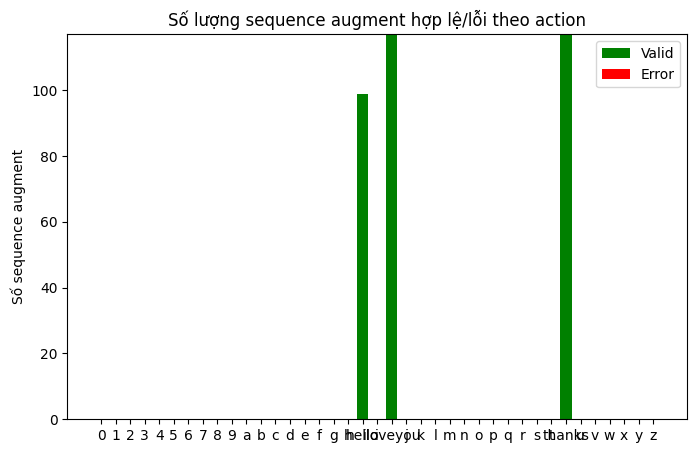

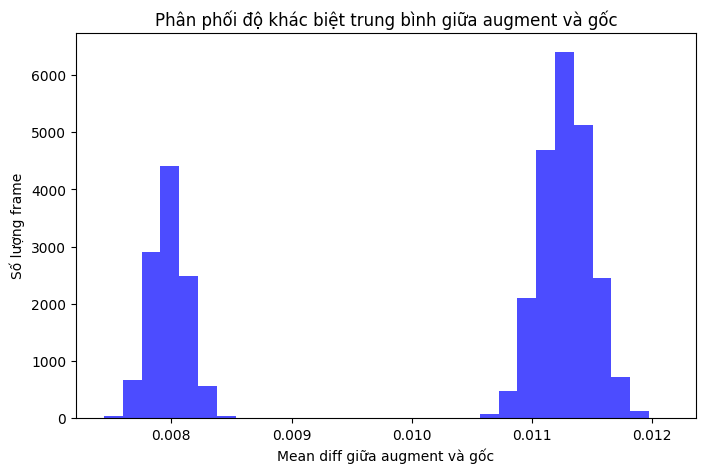

C:\Users\Admin\AppData\Local\Temp\ipykernel_2548\1494196835.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([action_stats[a]["diff_means"] for a in actions], labels=actions)


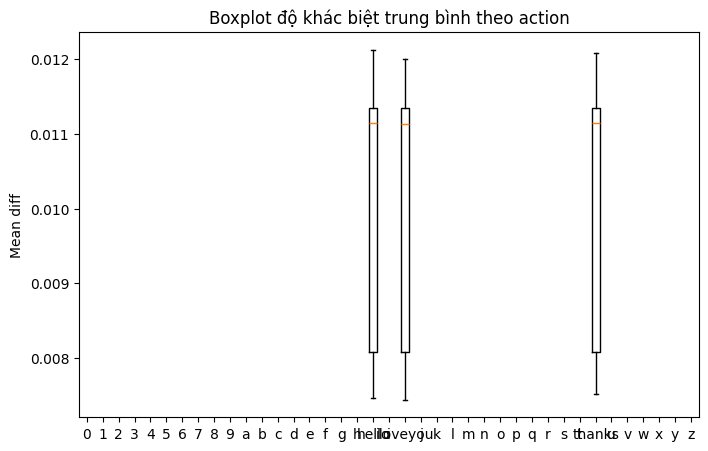

In [20]:
# Phân tích dữ liệu mô phỏng
analyze_augmented_sequences(DATA_PATH)